## Load results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyabc

h = pyabc.History("sqlite:///tumor2d_stoch_acc_v3.db")
h_incorrect = pyabc.History("sqlite:///tumor2d_incorrect_v3.db")
limits = dict(log_division_rate=(-3, -1),
              log_division_depth=(1, 3),
              log_initial_spheroid_radius=(0, 1.2),
              log_initial_quiescent_cell_fraction=(-5, 0),
              log_ecm_production_rate=(-5, 0),
              log_ecm_degradation_rate=(-5, 0),
              log_ecm_division_threshold=(-5, 0))

refval = dict(log_division_rate=4.17e-2,
              log_initial_spheroid_radius=1.2e1,
              log_initial_quiescent_cell_fraction=7.5e-1,
              log_division_depth=100,
              log_ecm_production_rate=5e-3,
              log_ecm_degradation_rate=8e-4,
              log_ecm_division_threshold=1e-2,)
for key, val in refval.items():
    refval[key] = np.log10(val)
    
print(h.max_t, h_incorrect.max_t)

10 24


## Plot data

dict_keys(['growth_curve', 'extra_cellular_matrix_profile', 'proliferation_profile'])


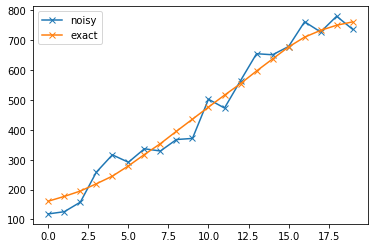

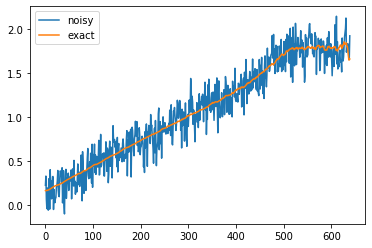

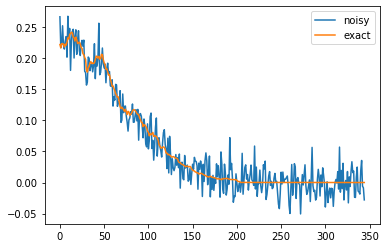

In [2]:
import pickle
import matplotlib.pyplot as plt

exact_data = pickle.load(open('exact_data_v3.dat', 'rb'))
noisy_data = pickle.load(open('noisy_data_v3.dat', 'rb'))

print(exact_data.keys())

for key in exact_data.keys():
    plt.subplots()
    plt.plot(noisy_data[key], 'x-', label='noisy')
    plt.plot(exact_data[key], 'x-', label='exact')
    plt.title(key)
    plt.legend()

/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/yannik/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/yannik/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


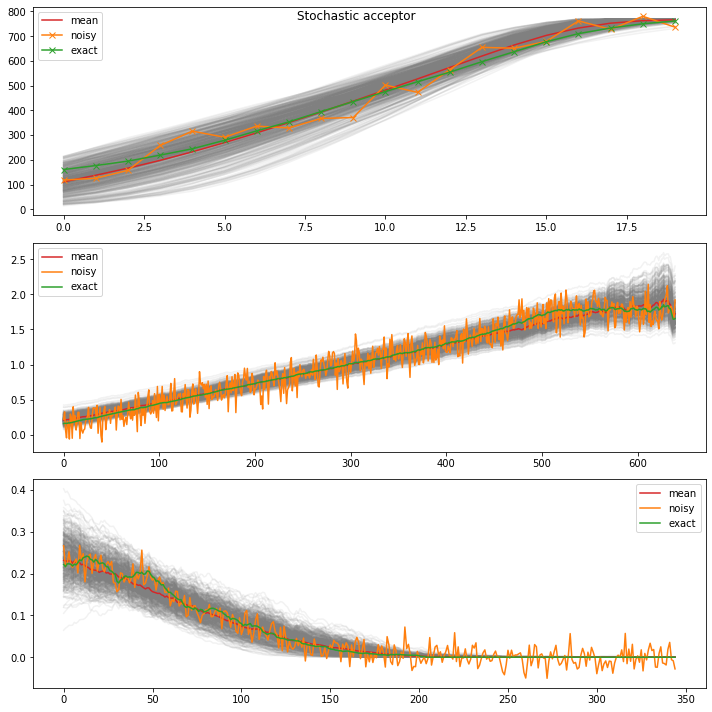

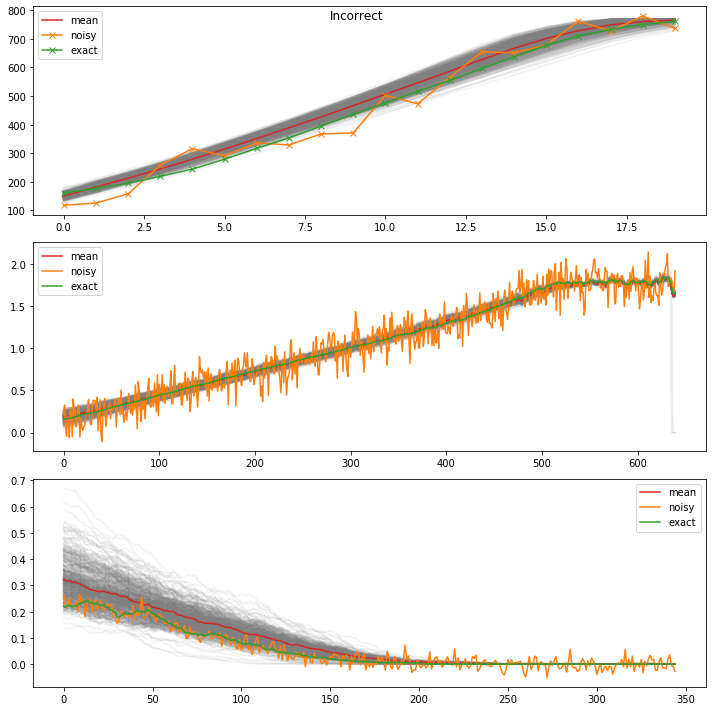

In [4]:
def plot_sum_stats(h, title):
    fig, arr_ax = plt.subplots(3, 1)

    def f_plot(sum_stat, weight, arr_ax, **kwargs):
        for i, key in enumerate(sum_stat.keys()):
            arr_ax[i].plot(sum_stat[key], '-', color='grey', alpha=min(20*weight, 1))
        
    def f_plot_mean(sum_stats, weights, arr_ax, **kwargs):
        aggregated = {}
        for key in sum_stats[0].keys():
            aggregated[key] = (np.array([sum_stat[key] for sum_stat in sum_stats]) \
                               * np.array(weights).reshape((-1,1))).sum(axis=0)
        for i, key in enumerate(aggregated.keys()):
            arr_ax[i].plot(aggregated[key], '-', color='C3', alpha=1, label='mean')

    pyabc.visualization.plot_data_callback(h, f_plot, f_plot_mean, ax=arr_ax)

    arr_ax[0].plot(noisy_data['growth_curve'], 'x-', color='C1', label='noisy')
    arr_ax[0].plot(exact_data['growth_curve'], 'x-', color='C2', label='exact')

    arr_ax[1].plot(noisy_data['extra_cellular_matrix_profile'], '-', color='C1', label='noisy')
    arr_ax[1].plot(exact_data['extra_cellular_matrix_profile'], '-', color='C2', label='exact')

    arr_ax[2].plot(noisy_data['proliferation_profile'], '-', color='C1', label='noisy')
    arr_ax[2].plot(exact_data['proliferation_profile'], '-', color='C2', label='exact')

    for ax in arr_ax: ax.legend()

    fig.set_size_inches((10, 10))
    fig.tight_layout()
    
plot_sum_stats(h)
plot_sum_stats(h_incorrect)

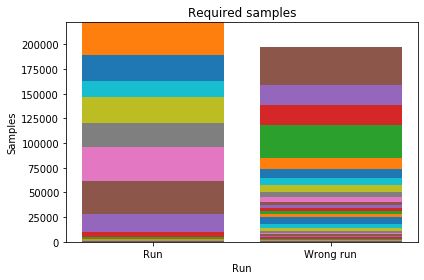

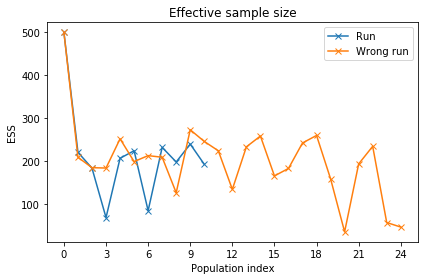

In [5]:
histories = [h, h_incorrect]
labels = ["Run", "Wrong run"]

pyabc.visualization.plot_sample_numbers(histories, labels)
pyabc.visualization.plot_effective_sample_sizes(histories, labels)

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'get_figure'

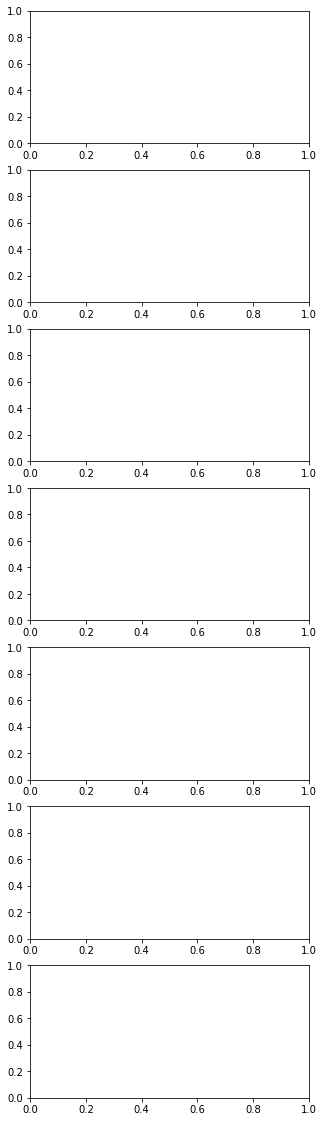

In [6]:
pyabc.visualization.plot_credible_intervals(h, size=(5, 20), refval=refval, levels=[0.9, 0.95])
pyabc.visualization.plot_credible_intervals(h_incorrect, size=(5, 20), refval=refval, levels=[0.9, 0.95])
plt.show()


24


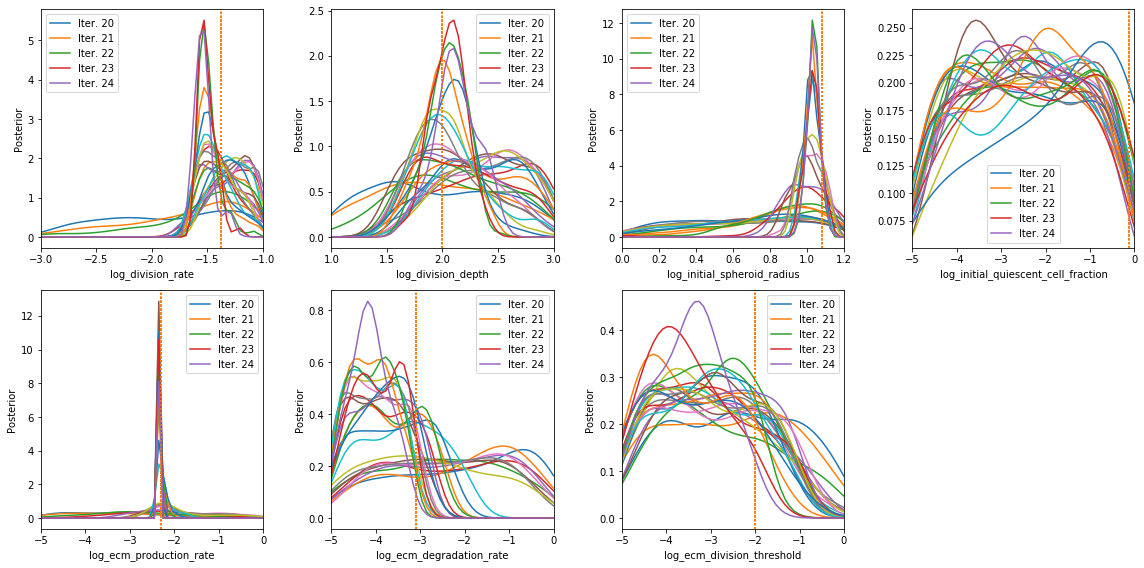

In [7]:
fig = plt.figure()
print(h_incorrect.max_t)

for ip, p in enumerate(limits):
    ax = fig.add_subplot(2, 4, ip+1)
    for t in range(h_incorrect.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(h_incorrect, t=t, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                                  ax=ax, refval=refval,
                                                  label=(f"Iter. {t}" if t > h_incorrect.max_t - 5 else ""))
    ax.legend()

fig.set_size_inches((16, 8))
fig.tight_layout()


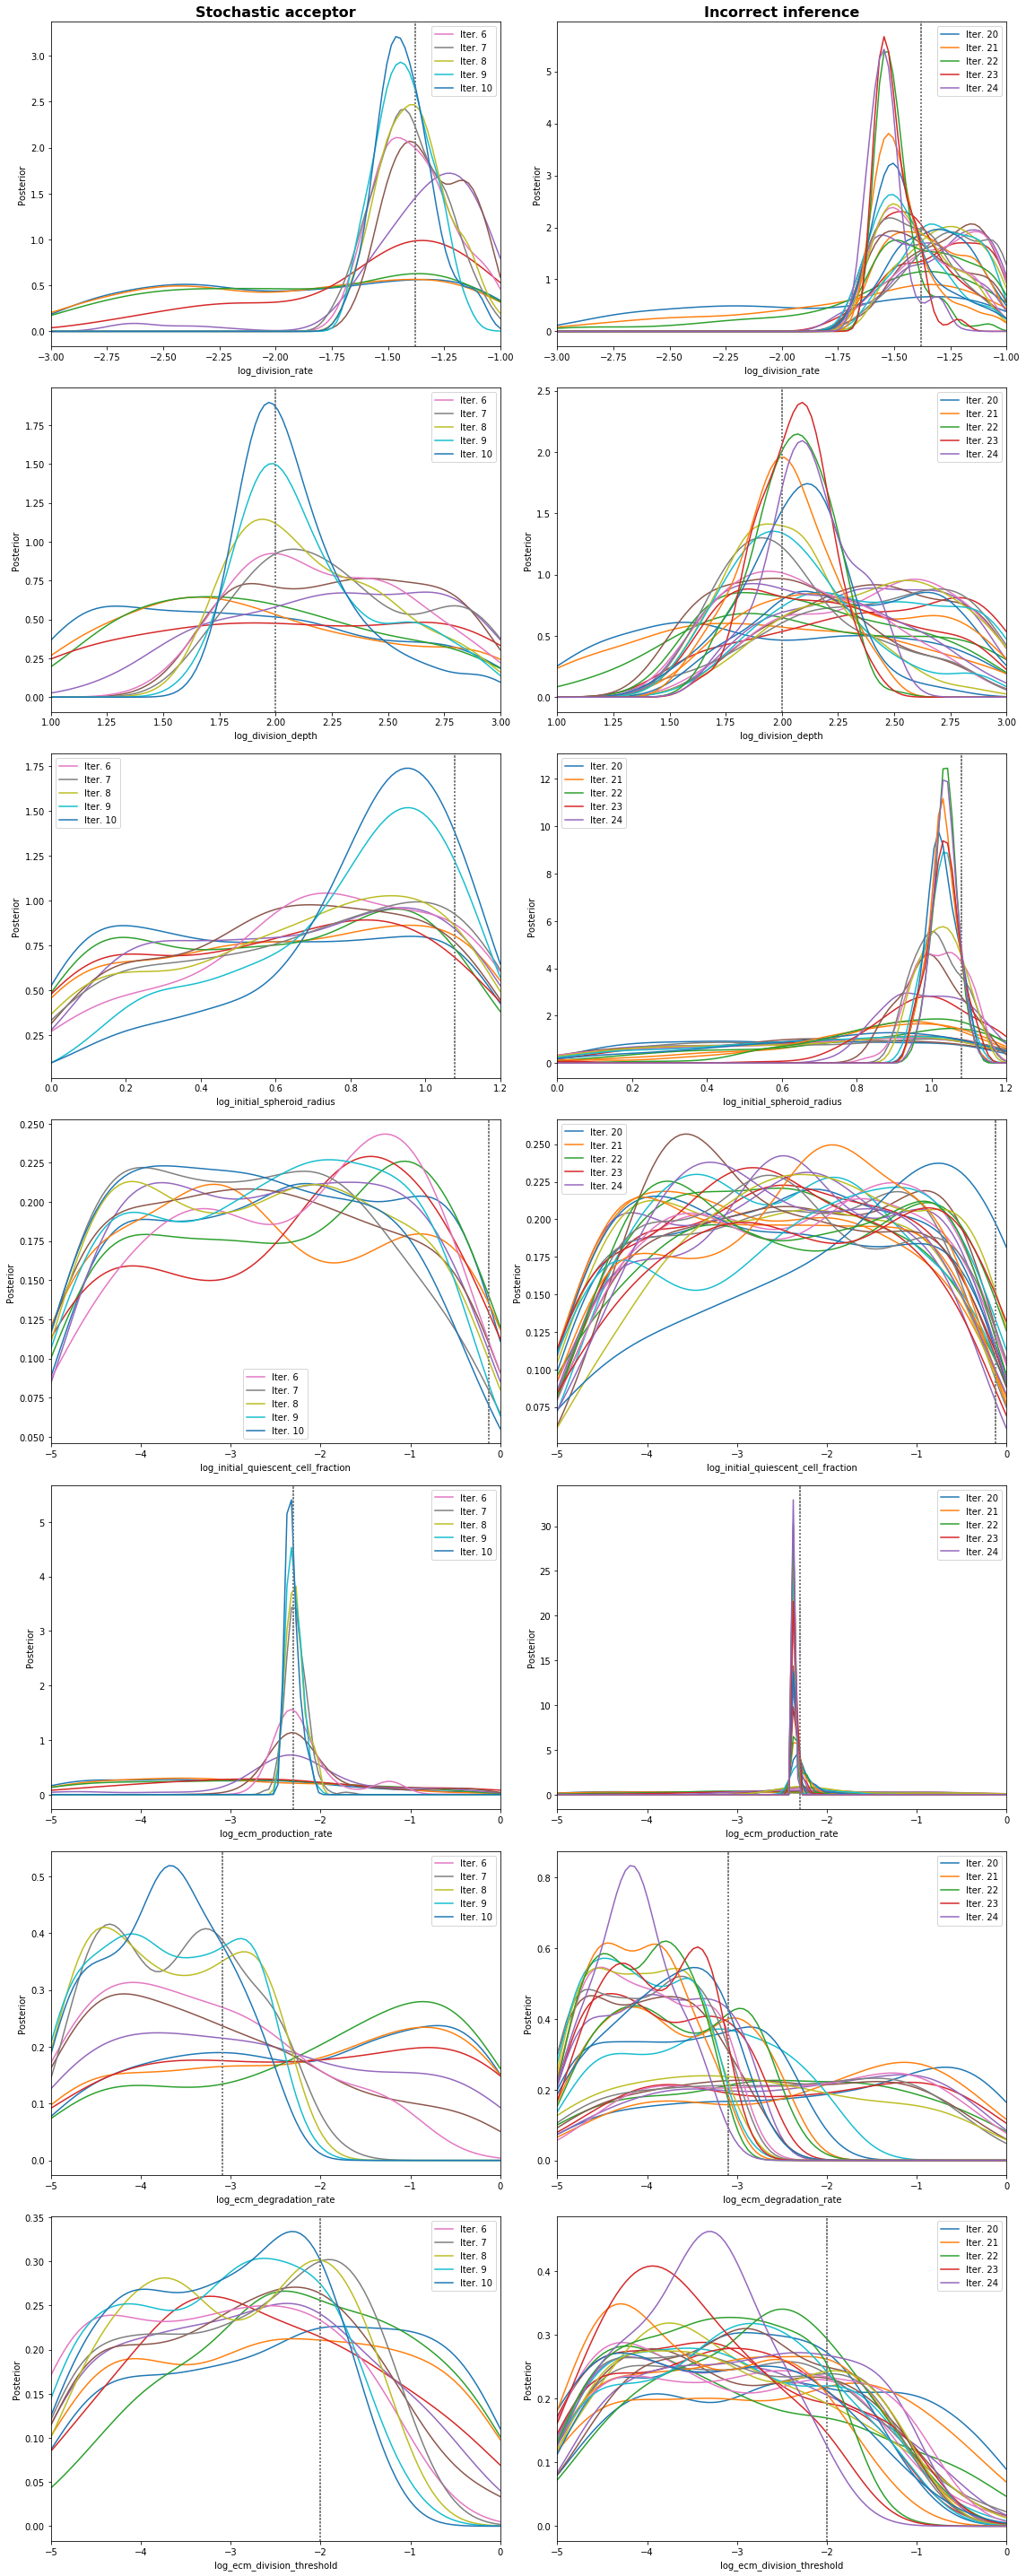

In [8]:
fig = plt.figure()

for ip, p in enumerate(limits):
    ax = fig.add_subplot(7, 2, 2*ip+1)
    for t in range(h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(h, t=t, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                                  ax=ax, label=(f"Iter. {t}" if t > h.max_t - 5 else ""),
                                                  numx=100, refval=refval,refval_color='grey')
    ax.legend()
    if ip==0:
        ax.set_title("Stochastic acceptor", fontsize=16, fontweight="bold")
    ax = fig.add_subplot(7, 2, 2*ip+2)
    for t in range(h_incorrect.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(h_incorrect, t=t, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                                  ax=ax, numx=100, refval=refval, refval_color='grey',
                                                  label=(f"Iter. {t}" if t > h_incorrect.max_t - 5 else ""))
    if ip==0:
        ax.set_title("Incorrect inference", fontsize=16, fontweight="bold")
    ax.legend()

fig.set_size_inches((16, 40))
fig.tight_layout()

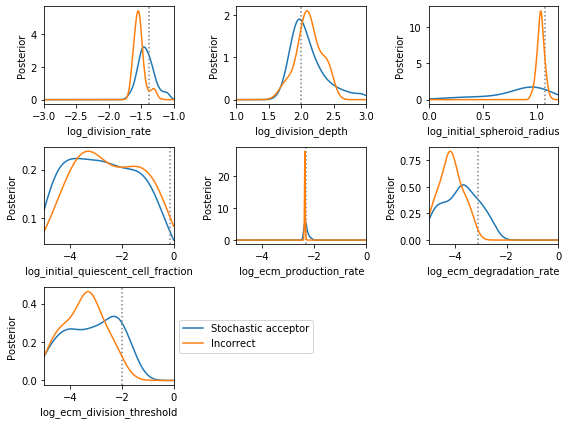

In [9]:
# only last iteration

fig = plt.figure()

for ip, p in enumerate(limits):
    ax = fig.add_subplot(3, 3, ip+1)
    pyabc.visualization.plot_kde_1d_highlevel(h, t=h.max_t, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                              ax=ax, label="Stochastic acceptor", refval=refval, refval_color='grey',
                                              numx=200)
    pyabc.visualization.plot_kde_1d_highlevel(h_incorrect, t=h_incorrect.max_t, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                              ax=ax, numx=200,
                                              label="Incorrect")
    
fig.set_size_inches((8, 6))
fig.tight_layout()

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("final_comparison.svg", format='svg')

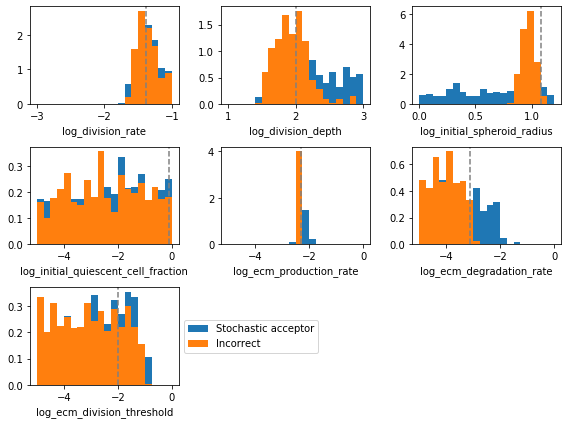

In [13]:
# only last iteration

fig = plt.figure()

for ip, p in enumerate(limits):
    ax = fig.add_subplot(3, 3, ip+1)
    pyabc.visualization.plot_histogram_1d(h, t=h.max_t, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                          ax=ax, label="Stochastic acceptor", refval=refval, refval_color='grey',
                                          bins=20)
    pyabc.visualization.plot_histogram_1d(h_incorrect, t=h_incorrect.max_t, x=p, xmin=limits[p][0], xmax=limits[p][1],
                                          ax=ax, bins=20,
                                          label="Incorrect")
    
fig.set_size_inches((8, 6))
fig.tight_layout()

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("final_comparison.svg", format='svg')

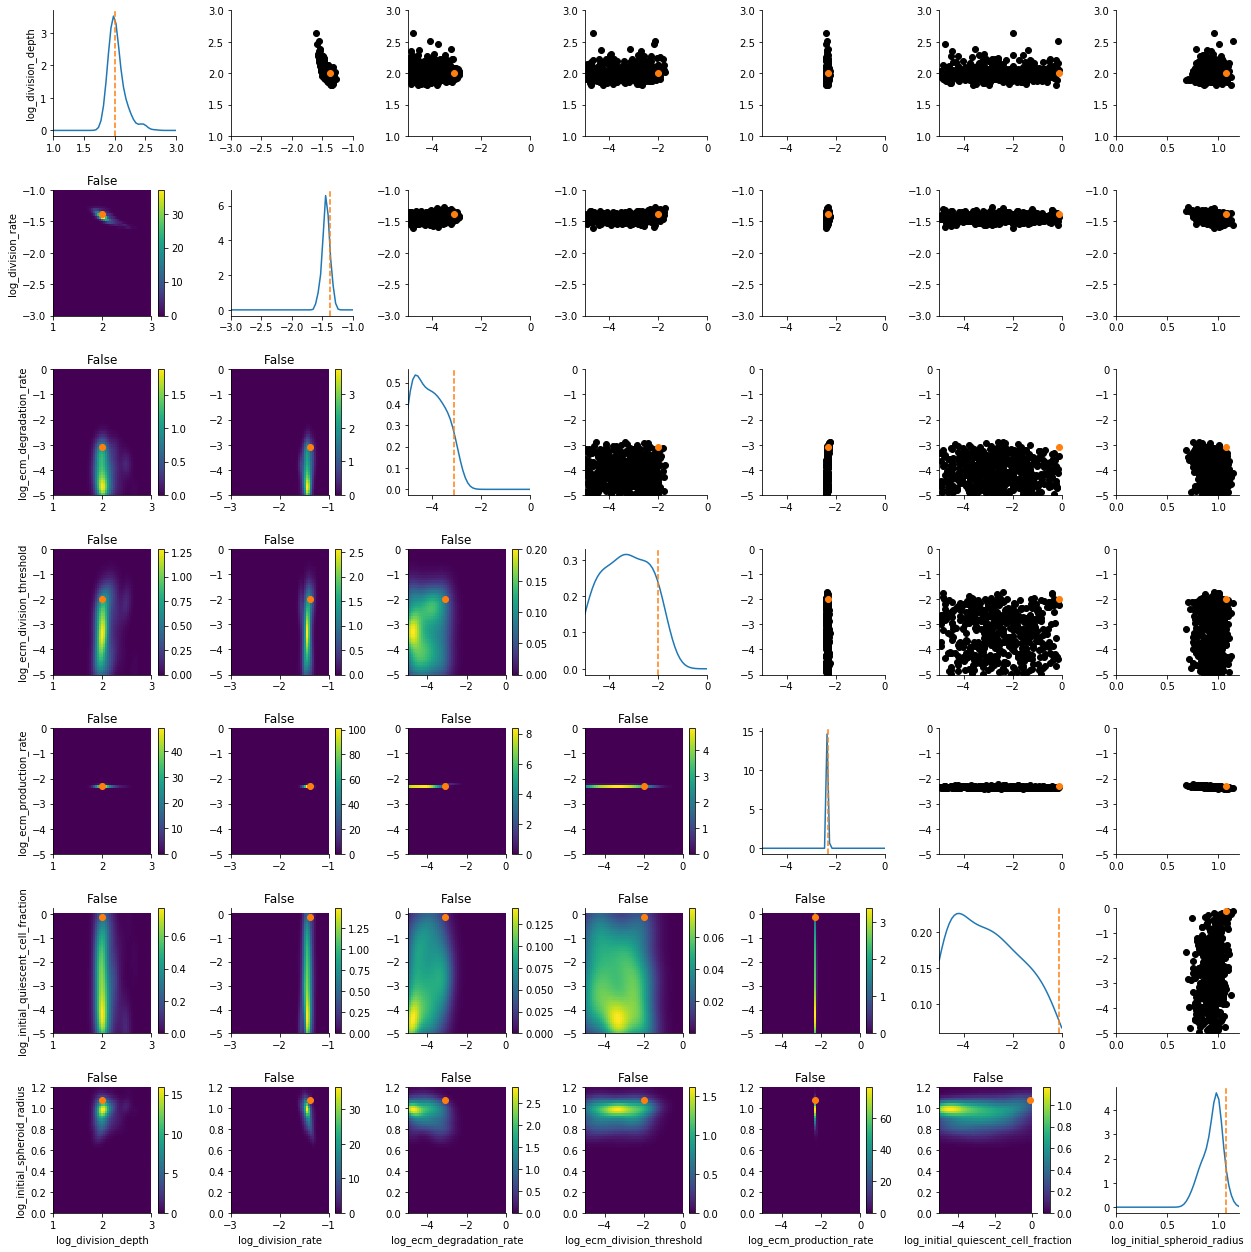

In [9]:
pyabc.visualization.plot_kde_matrix_highlevel(h, refval=refval, limits=limits)
plt.show()

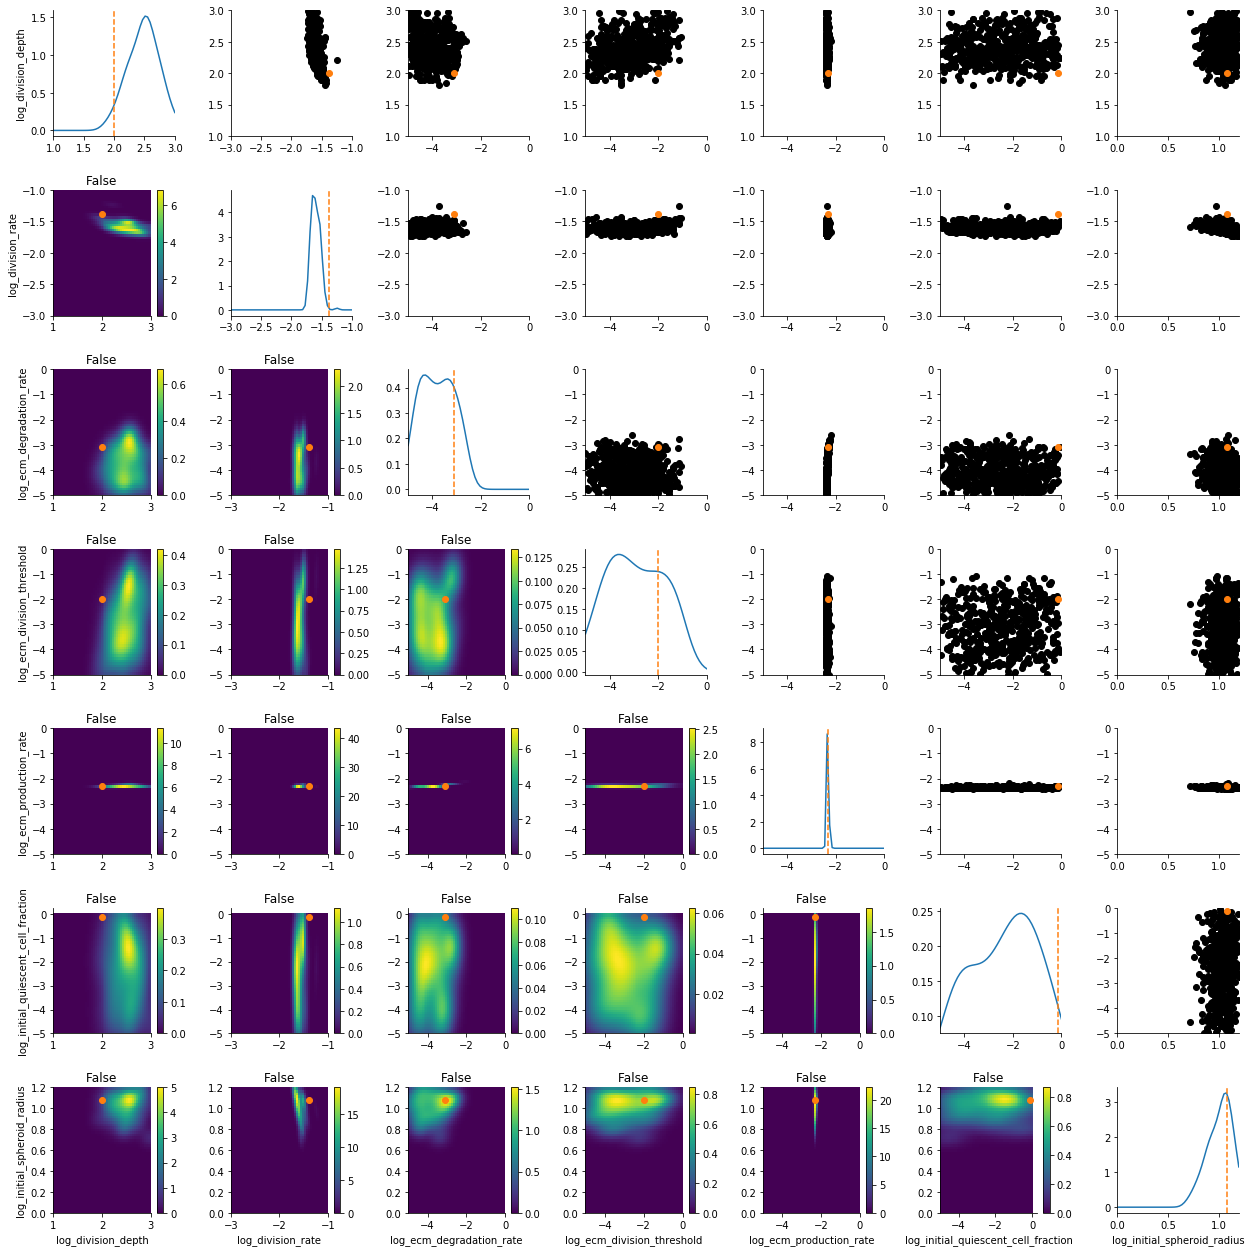

In [10]:
pyabc.visualization.plot_kde_matrix_highlevel(h_incorrect, refval=refval, limits=limits)
plt.show()